In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from complex_network.networks import network_factory, pole_calculator
from complex_network.networks.network_perturbator import NetworkPerturbator
from complex_network.networks.network_spec import NetworkSpec

Generate the network

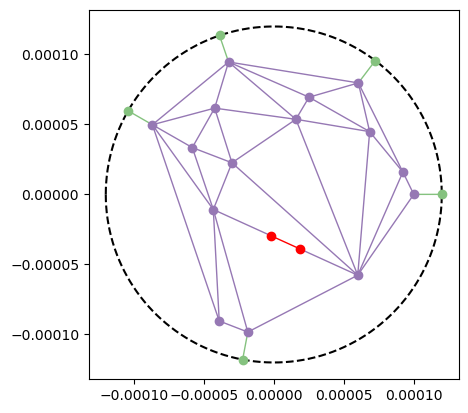

In [2]:
np.random.seed(1)
spec = NetworkSpec(
    network_type="delaunay",
    network_shape="circular",
    num_seed_nodes=0,
    external_offset=0.0,
    num_internal_nodes=15,
    num_external_nodes=5,
    network_size=100e-6,
    external_size=120e-6,
    node_S_mat_type="COE",
    node_S_mat_params={},
)
network = network_factory.generate_network(spec)
network.translate_node(10, np.array([0.00002, -0.00001]))
network.translate_node(6, np.array([0.0000, 0.00001]))
network.add_segment_to_link(9, [0.4, 0.6])
network.draw(
    equal_aspect=True,
    draw_boundary=120e-6,
    highlight_links=[34],
    highlight_nodes=[15, 16],
)

Perform a broad sweep to look for some scattering matrix poles

In [ ]:
d_lam = 2.5e-10
lam_centre = 550e-9
lam_min = lam_centre - d_lam
lam_max = lam_centre + d_lam
max_imag = -2500j
k0_min = 11420692.454866514 - 2500j
k0_max = 11429168.362309389 + 500j
num_points = 1 * 10**3

x, y, data = pole_calculator.sweep(k0_min, k0_max, num_points, network)

 11%|█         | 107/1000 [02:02<17:10,  1.15s/it]

Plot of the scattering matrix's determinant for different complex wavenumbers

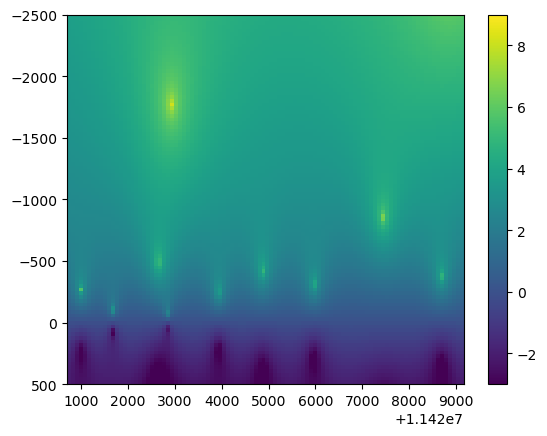

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data),
    extent=(k0_min.real, k0_max.real, 500, max_imag.imag),
    aspect="auto",
    vmin=-3,
    vmax=9,
)
cbar = fig.colorbar(im)

Hone in on the poles identified in the previous figure

In [ ]:
pole_guesses = 1.142e7 + np.array(
    [
        1000 - 300j,
        1500 - 100j,
        2500 - 500j,
        2500 - 100j,
        3000 - 1750j,
        4000 - 200j,
        5000 - 400j,
        6000 - 300j,
        7500 - 900j,
        8500 - 400j,
    ]
)
poles = np.array(
    [pole_calculator.find_pole(network, guess) for guess in pole_guesses]
)

Calculate the pole shift data for a series of refractive index perturbations

In [ ]:
link_index = 34

# Positive refractive index perturbations
perturbator = NetworkPerturbator(network)
Dn_values = np.array([0.0] + np.linspace(1e-4, 2e-1, 2500))
poles_dict, pole_shifts_dict = perturbator.track_pole_segment_n(
    poles, link_index, Dn_values
)

# Negative refractive index perturbations
perturbator = NetworkPerturbator(network)
Dn_values = np.array([0.0] + np.linspace(-1e-4, -2e-1, 2500))
poles_dict_negative, pole_shifts_dict_negative = (
    perturbator.track_pole_segment_n(poles, link_index, Dn_values)
)

  1%|          | 17/2499 [05:18<12:53:17, 18.69s/it]

In [ ]:
# Plot the initial pole landscape
plot_data = np.flip(data, axis=1)

size_x = 10
size_y = 5

fig, ax = plt.subplots(figsize=(size_x, size_y))

# Set graph limits
graph_x_min = (poles[0].real + 3 * poles[1].real) / 4
graph_x_max = k0_max.real
graph_y_min = 500
graph_y_max = max_imag.imag

ax.set_xlim(graph_x_min, graph_x_max)
ax.set_ylim(graph_y_min, graph_y_max)
num_x_ticks = 6
c = 299792458
k_ticks = [
    graph_x_min + (graph_x_max - graph_x_min) * i / (num_x_ticks - 1)
    for i in range(num_x_ticks)
]
w_ticks = [k_tick * c / 1e12 for k_tick in k_ticks]
w_ticklabels = [f"{w_tick:.1f}" for w_tick in w_ticks]
ax.set_xticks(k_ticks)
ax.set_xticklabels(w_ticklabels)

vmax = 8
vmin = -3

# Background plot
im = ax.imshow(
    -np.log(data),
    extent=(graph_x_min, graph_x_max, graph_y_min, graph_y_max),
    aspect="auto",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
)
cbar = fig.colorbar(im)
cbar_ticks = range(vmin, vmax + 1)
cbar.set_ticks(cbar_ticks)

# Red lines
indices = [2, 4, 5, 6, 8, 9]
for line_type, color in zip(["direct", "volume"], ["white", "red"]):
    for i, poles_list in enumerate(np.array(poles_dict[line_type])[indices]):
        xs = np.array([p.real for p in poles_list])
        ys = np.array([p.imag for p in poles_list])

        index = -1
        ax.plot(
            xs[:index], ys[:index], color=color, label=line_type, linewidth=2
        )

# Dashed red lines
indices_negative = [8, 9]
for line_type, color in zip(["direct", "volume"], ["white", "red"]):
    for i, poles_list in enumerate(
        np.array(poles_dict_negative[line_type])[indices_negative]
    ):
        xs = np.array([p.real for p in poles_list])
        ys = np.array([p.imag for p in poles_list])

        ax.plot(
            xs[:index],
            ys[:index],
            color=color,
            label=line_type,
            linewidth=2,
            linestyle="--",
        )

# White crosses
ax.scatter(
    np.real(poles)[indices],
    np.imag(poles)[indices],
    color="white",
    marker="x",
    s=100,
    zorder=3,
)
remaining_indices = [0, 1, 3, 7]
ax.scatter(
    np.real(poles)[remaining_indices],
    np.imag(poles)[remaining_indices],
    color="white",
    marker="o",
    s=50,
    zorder=3,
)
ax.scatter(
    np.real(big_pole),
    np.imag(big_pole),
    color="white",
    marker="o",
    s=50,
    zorder=3,
)
